# Calculating Allan Deviation

Use this notebook to check frequency stability compared to or between GPSDO devices.
This was designed to check through binary IQ data.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import scipy.signal as signal


In [2]:
#complex data generation from IQ files
#taking large fft size and finding precise peaks using peak finder fn
#forming data arrays of the peaks for the two known frequencies on each radio


sample_rate = 48000
filesize = 52e9
float32seg = int(2**21)
summaryarrayettus = []
summaryarraypinoclock = []
summaryarraypiwithclock = []
for i in range(int(filesize/8/float32seg)):
  loopdat1 = np.fromfile("/home/kaeppler-nuc/longtermdataettusclocked.txt", dtype="float32",offset=float32seg+(i*float32seg),count=float32seg)
  loopdat1 = loopdat1[0::2] + 1j*loopdat1[1::2]
  #if loopdat1 >= int(float32seg/2):
  f1, S1 = signal.periodogram(loopdat1, sample_rate, scaling = 'spectrum',nfft = int(float32seg/2),window=signal.hamming(int(float32seg/2),False),return_onesided = False)
  #plt.semilogy(f1, S1)
  peaks = signal.find_peaks(S1,height=1e-13)
  loopfreqs = np.sort(f1[peaks[0]])
  summaryarrayettus.append([loopfreqs[0],loopfreqs[-1]])
  #else:
    #break
#print(loopfreqs)
#print(summaryarrayettus)



for i in range(int(filesize/8/float32seg)):
  loopdat = np.fromfile("/home/kaeppler-nuc/longtermdatapiunclocked.txt", dtype="float32",offset=float32seg+(i*float32seg),count=float32seg)
  loopdat = loopdat[0::2] + 1j*loopdat[1::2]

  f2, S2 = signal.periodogram(loopdat, sample_rate, scaling = 'spectrum',nfft = int(float32seg/2),window=signal.hamming(int(float32seg/2),False),return_onesided = False)
  #plt.semilogy(f2, S2)
  peaks = signal.find_peaks(S2,height=2e-7)
  loopfreqs = np.sort(f2[peaks[0]])
  summaryarraypinoclock.append([loopfreqs[0],loopfreqs[-1]])
#print(summaryarraypinoclock)

for i in range(int(filesize/8/float32seg)):
  loopdat2 = np.fromfile("/home/kaeppler-nuc/longtermdatapiclocked.txt", dtype="float32",offset=float32seg+(i*float32seg),count=float32seg)
  loopdat2 = loopdat2[0::2] + 1j*loopdat2[1::2]

  f3, S3 = signal.periodogram(loopdat2, sample_rate, scaling = 'spectrum',nfft = int(float32seg/2),window=signal.hamming(int(float32seg/2),False),return_onesided = False)
  #plt.semilogy(f2, S2)
  peaks = signal.find_peaks(S3,height=2e-7)
  loopfreqs = np.sort(f3[peaks[0]])
  summaryarraypiwithclock.append([loopfreqs[0],loopfreqs[-1]])
#print(summaryarraypiwithclock)

[-0.4119873 -0.4119873 -0.4119873 ... -0.4119873 -0.4119873 -0.4119873]
[-4.89807129 -4.89807129 -4.89807129 ... -4.96673584 -4.96673584
 -4.96673584]


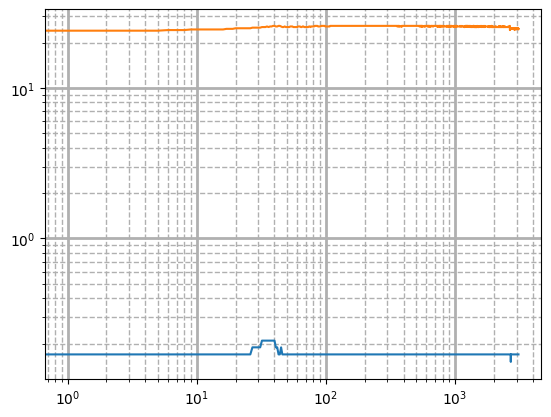

In [3]:
#Just a diagnostic visualization tool, discard later

time = np.linspace(0,int(filesize/8/float32seg),int(len(summaryarrayettus)))
print(np.subtract(np.mean(summaryarrayettus,axis=1) , np.mean(summaryarraypiwithclock,axis=1)))
print(np.subtract(np.mean(summaryarrayettus,axis=1) , np.mean(summaryarraypinoclock,axis=1)))

plt.figure(3)
plt.plot(time,(np.subtract(np.mean(summaryarrayettus,axis=1) , np.mean(summaryarraypiwithclock,axis=1))**2))
plt.plot(time,(np.subtract(np.mean(summaryarrayettus,axis=1) , np.mean(summaryarraypinoclock,axis=1))**2))
plt.loglog()
plt.grid(visible=True, which='major', linewidth=2, linestyle='-')
plt.grid(visible=True, which='minor', linewidth=1, linestyle='--')

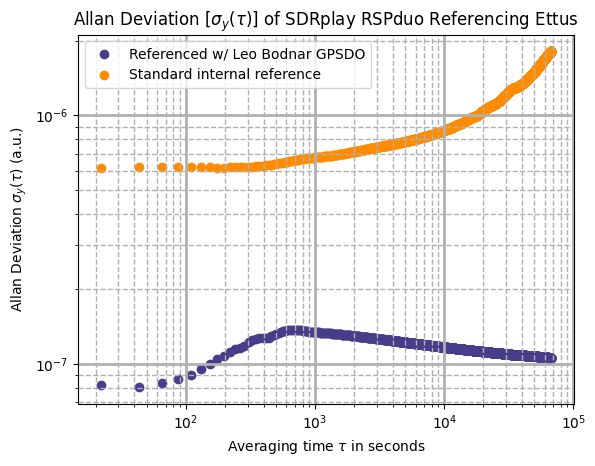

In [13]:

#calculating fractional frequencies for Leo Bodnar attached


Xf1clock = np.divide(np.subtract(np.array(summaryarrayettus)[:,0], np.array(summaryarraypiwithclock)[:,0]),np.array(summaryarrayettus)[:,0])
Xf2clock = np.divide(np.subtract(np.array(summaryarrayettus)[:,1], np.array(summaryarraypiwithclock)[:,1]),np.array(summaryarrayettus)[:,1])
Xfclock = (np.abs(Xf1clock) + np.abs(Xf2clock))/2
#print(Xfclock.shape)
Xfclockdiff = []
allandevclock = []
tauclock = []

#calculating allan deviation for every two samples of the fractional frequencies
#added if statement to deal with remainder issues on reshaping the arrays
#looping through every possible timescale (tau) value and appending to an array
for m in range(len(Xfclock)):
    if len(Xfclock) % (m+1) == 0:
        Xftauavg = np.mean(Xfclock.reshape(-1,m+1),axis = 1)
        taupoint = (m+1)*int(float32seg/2)/sample_rate
        tauclock.append(taupoint)
        for k in range(len(Xftauavg)-1):
            diff = ((Xftauavg[k+1] - Xftauavg[k]))**2
            Xfclockdiff.append(diff)
        allanvarclock = 0.5*np.mean(np.array(Xfclockdiff))
        allandevclock.append(np.sqrt(allanvarclock))
        #print(allandev)
    else:
        paddingneeded = (m+1)-(len(Xfclock) % (m+1))
        Xftauavg = np.mean(np.reshape(np.pad(Xfclock,(0,paddingneeded),'edge'),(-1,m+1)), axis=1)
        taupoint = (m+1)*int(float32seg/2)/sample_rate
        tauclock.append(taupoint)
        for p in range(len(Xftauavg)-1):
            diff = ((Xftauavg[p+1] - Xftauavg[p]))**2
            Xfclockdiff.append(diff)
        allanvarnoclock = 0.5*np.mean(np.array(Xfclockdiff))
        allandevclock.append(np.sqrt(allanvarnoclock))
        #print(allandev)

#same thing as above, but for no reference clock attached to the RSPduo

Xf1noclock = np.divide(np.subtract(np.array(summaryarrayettus)[:,0], np.array(summaryarraypinoclock)[:,0]),np.array(summaryarrayettus)[:,0])
Xf2noclock = np.divide(np.subtract(np.array(summaryarrayettus)[:,1], np.array(summaryarraypinoclock)[:,1]),np.array(summaryarrayettus)[:,1])
Xfnoclock = (np.abs(Xf1noclock) + np.abs(Xf2noclock))/2

Xfnoclockdiff = []
allandevnoclock = []
taunoclock = []
for n in range(len(Xfnoclock)):
    if len(Xfnoclock) % (n+1) == 0:
        Xftauavg = np.mean(Xfnoclock.reshape(-1,n+1),axis = 1)
        taupoint = (n+1)*int(float32seg/2)/sample_rate
        taunoclock.append(taupoint)
        for p in range(len(Xftauavg)-1):
            diff = ((Xftauavg[p+1] - Xftauavg[p]))**2
            Xfnoclockdiff.append(diff)
        allanvarnoclock = 0.5*np.mean(np.array(Xfnoclockdiff))
        allandevnoclock.append(np.sqrt(allanvarnoclock))
        #print(allandev)
    else:
        paddingneeded = (n+1)-(len(Xfnoclock) % (n+1))
        Xftauavg = np.mean(np.reshape(np.pad(Xfnoclock,(0,paddingneeded),'edge'),(-1,n+1)), axis=1)
        taupoint = (n+1)*int(float32seg/2)/sample_rate
        taunoclock.append(taupoint)
        for p in range(len(Xftauavg)-1):
            diff = ((Xftauavg[p+1] - Xftauavg[p]))**2
            Xfnoclockdiff.append(diff)
        allanvarnoclock = 0.5*np.mean(np.array(Xfnoclockdiff))
        allandevnoclock.append(np.sqrt(allanvarnoclock))
        #print(allandev)



#plotting the Allan Deviation figure

plt.figure(4)
plt.scatter(tauclock,allandevclock,label = "Referenced w/ Leo Bodnar GPSDO",c="darkslateblue")
plt.scatter(taunoclock,allandevnoclock,label = "Standard internal reference",c ="darkorange")
plt.ylabel(r"Allan Deviation $\sigma_y(\tau)$ (a.u.)")
plt.xlabel(r"Averaging time $\tau$ in seconds")
plt.title(r"Allan Deviation $[\sigma_y(\tau)]$ of SDRplay RSPduo Referencing Ettus")
plt.legend()
plt.loglog()
plt.grid(visible=True, which='major', linewidth=2, linestyle='-')
plt.grid(visible=True, which='minor', linewidth=1, linestyle='--')
plt.savefig("AllanDeviationRSPduoResults.png")
